In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import re
from scipy import interpolate
# 図のスタイル設定
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)

print("ライブラリ読み込み完了")
import japanize_matplotlib


ライブラリ読み込み完了


In [2]:
def make_time_row(df):
    df["time"] = np.arange(0, len(df)) / 100
    return df
def get_first_trigger_segment(df, trigger_col="value", trigger_value=2):
    """
    最初のトリガー値(trigger_value)が立ってから
    次のトリガーが立つ直前までの区間を返す。
    """

    trigger_idx = df.index[df[trigger_col] >= trigger_value].tolist()
    print(trigger_idx)


    if len(trigger_idx) == 0:
        return None  # トリガーが無い

    # 最初のトリガー開始
    start = trigger_idx[0]

    # 次のトリガーがあるか？
    # if len(trigger_idx) >= 2:
        # end = trigger_idx[-1]
    # else:
    end = df.index[-1]  # トリガーが1回だけの場合、最後まで
    
    print(start,end)

    return df.loc[start:end].reset_index(drop=True)

def fix_columns(df):
    cleaned = [re.sub(r'\.\d+$', '', c) for c in df.columns]  # .1 や .2 を除去
    new_cols = []
    seen = {}

    for col in cleaned:
        if col not in seen:
            seen[col] = 1
            new_cols.append(f"{col}_1")
        else:
            seen[col] += 1
            new_cols.append(f"{col}_{seen[col]}")

    df.columns = new_cols
    return df

def estimate_sampling_rate(df):
    t = df['time'].values
    # 時刻差分（dt）を計算
    dt = np.diff(t)
    # 正の値のみ（たまに逆順やゼロが混ざるため）
    dt = dt[dt > 0]
    # メジアンをサンプリング周期とする
    dt_med = np.median(dt)
    # sampling rate [Hz]
    fs = 1.0 / dt_med
    return fs, dt_med


In [3]:
data_info = pd.read_excel(r"C:\Users\youli\Desktop\code\20251118_COPモドキ\info.xlsx")
data_info

,sub,seat,cop,pedal,steer,label
0,A,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,2F
1,B,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,2F
2,A,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,3F


[286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 27358, 27359, 27360, 27361, 27362, 27363, 27364, 27365, 27366, 27367]
286 29999
Sampling rate: 41.66666666666509 Hz


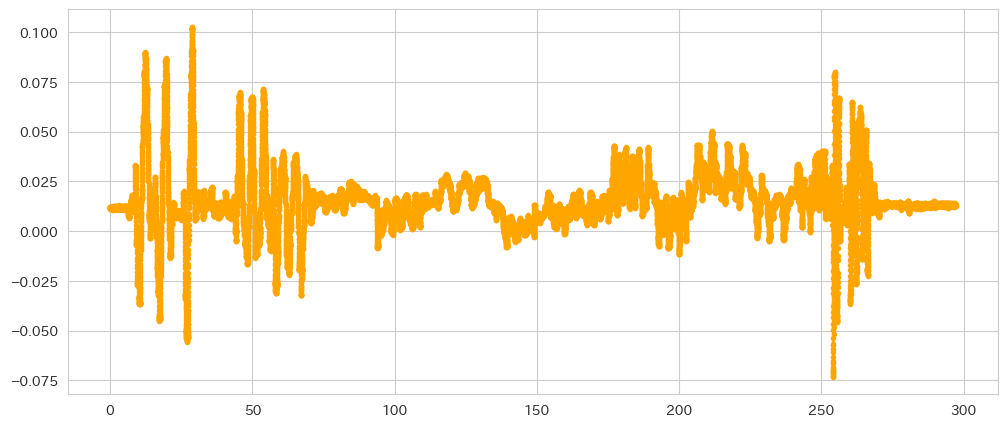

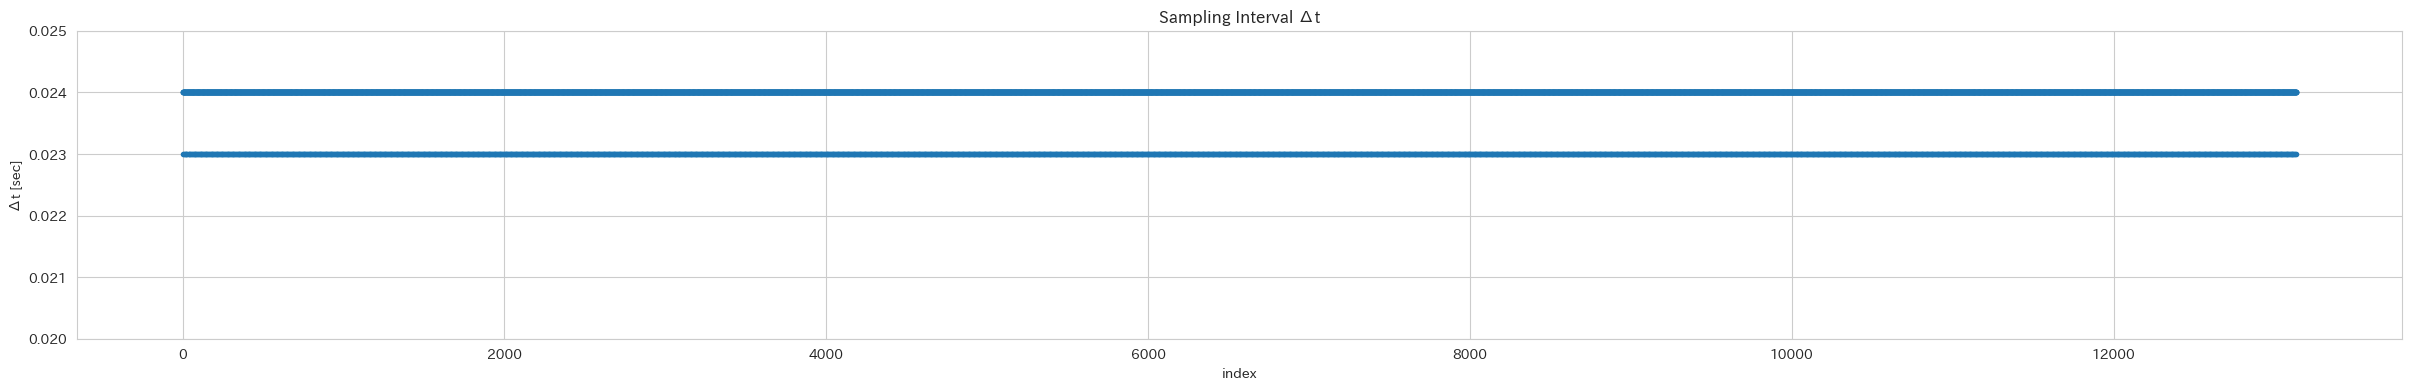

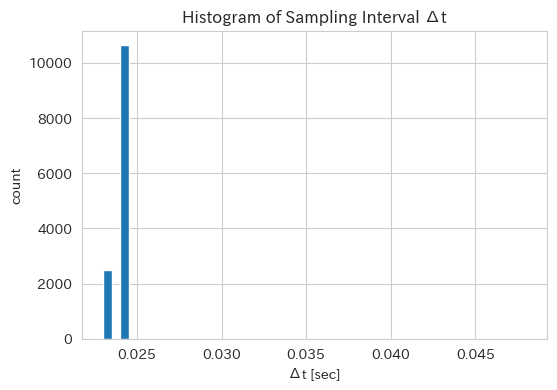

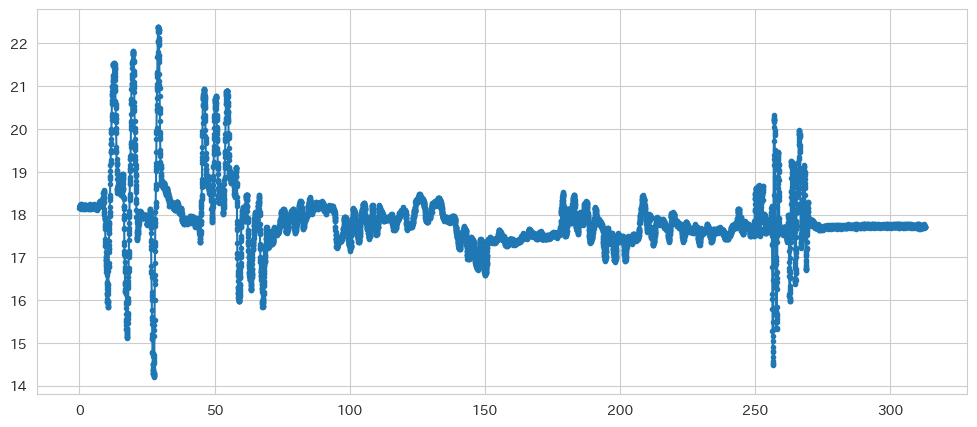

In [4]:
for num, idx in enumerate(data_info.index): 
    row = data_info.iloc[idx,:] 
    sub_ = row['sub'] 
    seat_path = row['seat']
    cop_path = row['cop']
    pedal_path = row['pedal']
    steer_path = row['steer']
    label = row['label']

    df_seat = pd.read_csv(seat_path,skiprows=1)
    df_cop = pd.read_csv(cop_path,skiprows=21)
    df_pedal = pd.read_csv(pedal_path,skiprows=21)
    df_steer = pd.read_csv(steer_path,skiprows=21)

    
    df_pedal.rename(columns={'Untitled 4':'pedal'},inplace=True)
    df_steer.rename(columns={'Untitled 1':'steer','Untitled 2':'trg'},inplace=True)
    df_cop.rename(columns={'Untitled 2':'COP_X','Untitled 3':'COP_Y'},inplace=True)
    df_pedal = make_time_row(df_pedal)
    df_steer = make_time_row(df_steer)
    df_cop = make_time_row(df_cop)
    
    df_mock = pd.merge(df_cop[['time','COP_X','COP_Y']], df_steer[['time','steer','trg']], on='time', how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)') 
    df_mock = pd.merge(df_mock, df_pedal[['time','pedal']], on='time', how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)') 


    df_mock_tmp = get_first_trigger_segment(df_mock, trigger_col="trg", trigger_value=1)
    df_mock_tmp['time'] -= df_mock_tmp['time'].iloc[0]
    plt.plot(df_mock_tmp.time,df_mock_tmp['COP_X'],'.-',color='orange')

    df_seat = fix_columns(df_seat)
    df_seat['time'] = df_seat['時間_1']
    fs, dt = estimate_sampling_rate(df_seat)
    print("Sampling rate:", fs, "Hz")

    # time 差分（サンプリング間隔）
    dt = df_seat['time'].diff()

    plt.figure(figsize=(30,4))
    plt.plot(dt,'.')
    plt.title("Sampling Interval Δt")
    plt.xlabel("index")
    plt.ylabel("Δt [sec]")
    plt.ylim(0.020,0.025)
    plt.grid(True)
    plt.show()


    plt.figure(figsize=(6,4))
    plt.hist(dt.dropna(), bins=50)
    plt.title("Histogram of Sampling Interval Δt")
    plt.xlabel("Δt [sec]")
    plt.ylabel("count")
    plt.grid(True)
    plt.show()



    plt.plot(df_seat.time,df_seat['圧力中心列_2'],'.-')

    
    break


# リサンプリング

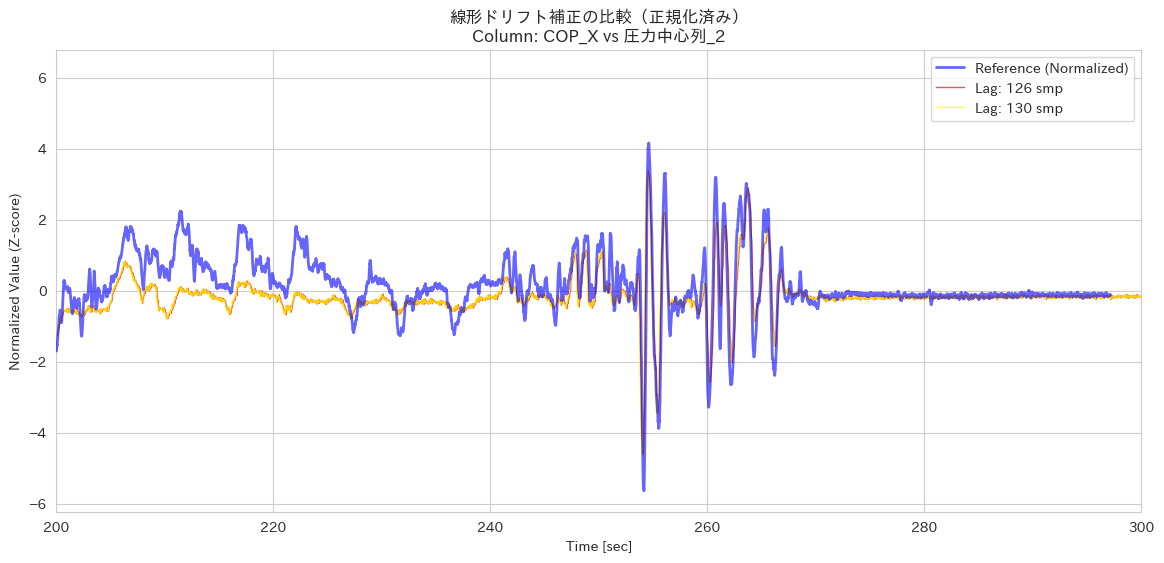

In [5]:
def visualize_linear_drifts_normalized(df_ref, df_target, drift_samples_list, 
                                     col_ref='COP_X', col_target='圧力中心列_2'):
    """
    線形ドリフトの比較（正規化付き）
    縦軸のスケールが異なるデータを、正規化して重ね書きします。
    """
    
    # --- 1. 前処理: 正規化 (Z-score normalization) ---
    # 平均を引いて標準偏差で割ることで、両方の波形を似たようなサイズにします
    ref_data = df_ref[col_ref]
    ref_norm = (ref_data - ref_data.mean()) / ref_data.std()
    
    target_data = df_target[col_target]
    target_norm = (target_data - target_data.mean()) / target_data.std()
    
    # --- 2. 時間軸計算の準備 ---
    dt_mean = df_target['time'].diff().mean()
    t_start = df_target['time'].min()
    t_end_orig = df_target['time'].max()
    duration = t_end_orig - t_start
    
    plt.figure(figsize=(14, 6))
    
    # --- 3. 正解データのプロット（青・太線） ---
    # 正規化した値を使います
    plt.plot(df_ref['time'], ref_norm, color='blue', linewidth=2,alpha = 0.6, label='Reference (Normalized)', zorder=10)
    
    # 色の準備
    colors = plt.cm.autumn(np.linspace(0, 1, len(drift_samples_list)))
    
    # --- 4. 各ドリフト量ごとのシミュレーション ---
    for i, drift_samples in enumerate(drift_samples_list):
        
        # ズレ時間の計算
        total_lag_time = drift_samples * dt_mean
        
        # 伸縮率 (Scale Factor)
        scale_factor = duration / (duration + total_lag_time)
        
        # 時間軸の再計算（線形変換）
        # 時間tに応じて補正量が大きくなる
        new_time = t_start + (df_target['time'] - t_start) * scale_factor
        
        # プロット（正規化した値 target_norm を使用）
        plt.plot(new_time, target_norm, 
                 color=colors[i], 
                 linewidth=1, 
                 alpha=0.7,
                 linestyle='-',
                 label=f'Lag: {drift_samples} smp')

    # --- 5. 見やすさの調整 ---
    plt.title(f"線形ドリフト補正の比較（正規化済み）\nColumn: {col_ref} vs {col_target}")
    plt.xlabel("Time [sec]")
    plt.ylabel("Normalized Value (Z-score)")
    plt.legend(loc='upper right')
    plt.grid(True)
    
    # ★重要: ズレが顕著な「後半部分」を拡大表示（必要に応じてコメントアウトを外してください）
    # plt.xlim(0,100)
    plt.xlim(200,300)
    plt.show()

# ==========================================
# 実行
# ==========================================

# 試したいサンプルズレのリスト
try_drifts = [126,130] 

visualize_linear_drifts_normalized(
    df_mock_tmp, 
    df_seat, 
    try_drifts,
    col_ref='COP_X',         # df_ref (df_mock_tmp) の列名
    col_target='圧力中心列_2' # df_target (df_seat) の列名
)

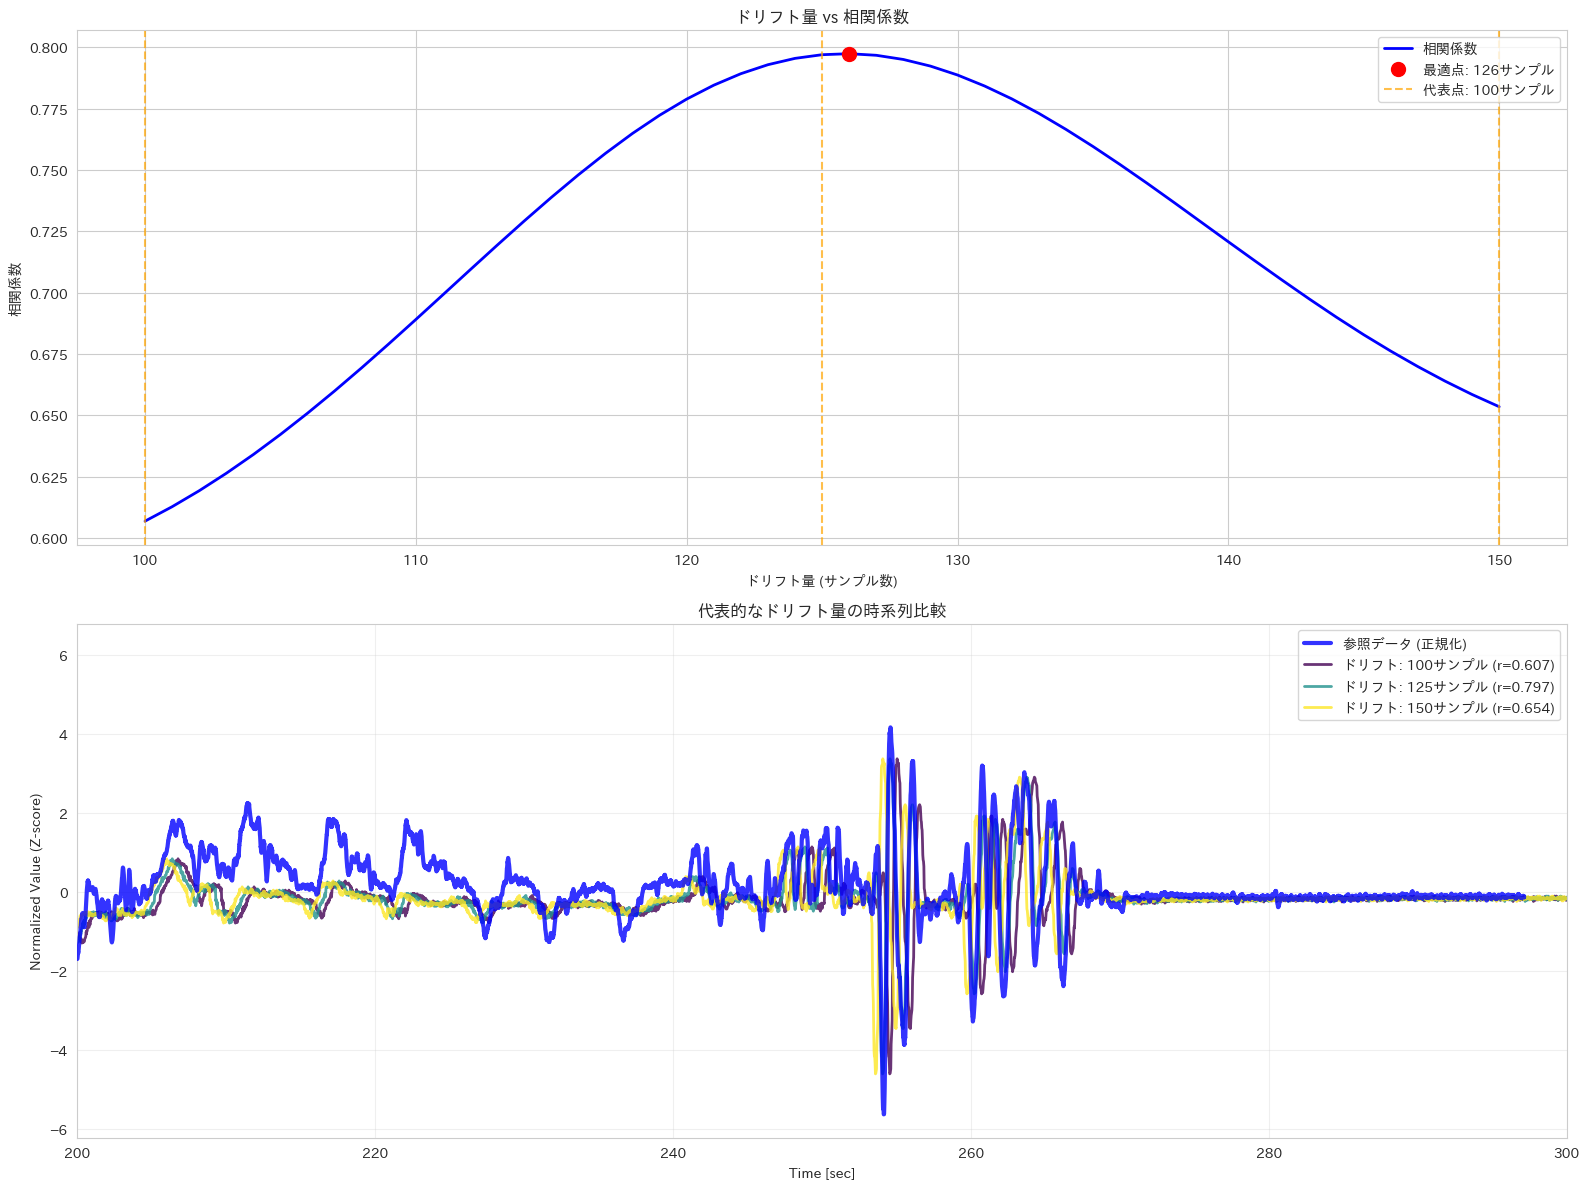


=== 探索結果サマリー ===
探索範囲: 100 ~ 150 サンプル
最適なドリフト量: 126 サンプル
最大相関係数: 0.7974

=== 代表サンプル詳細 ===
   ドリフト 100 サンプル: 相関係数 = 0.6069
   ドリフト 125 サンプル: 相関係数 = 0.7970
   ドリフト 150 サンプル: 相関係数 = 0.6536


In [6]:
def evaluate_linear_drifts_with_samples(df_ref, df_target, drift_range, 
                                       col_ref='COP_X', col_target='圧力中心列_2',
                                       num_sample_views=3):
    """
    線形ドリフトの評価＋代表的なサンプルを時系列グラフで表示
    """
    
    # --- 1. 前処理: 正規化 ---
    ref_data = df_ref[col_ref]
    ref_norm = (ref_data - ref_data.mean()) / ref_data.std()
    
    target_data = df_target[col_target]
    target_norm = (target_data - target_data.mean()) / target_data.std()
    
    # --- 2. 時間軸計算の準備 ---
    dt_mean = df_target['time'].diff().mean()
    t_start = df_target['time'].min()
    t_end_orig = df_target['time'].max()
    duration = t_end_orig - t_start
    
    # --- 3. 全範囲で相関計算 ---
    all_results = []
    for drift_samples in range(drift_range[0], drift_range[1] + 1):
        total_lag_time = drift_samples * dt_mean
        scale_factor = duration / (duration + total_lag_time)
        new_time = t_start + (df_target['time'] - t_start) * scale_factor
        
        # 補間
        from scipy import interpolate
        f_interp = interpolate.interp1d(new_time, target_norm, 
                                      bounds_error=False, fill_value='extrapolate')
        target_aligned = f_interp(df_ref['time'])
        
        # 相関計算
        valid_mask = ~np.isnan(target_aligned)
        if np.sum(valid_mask) > 10:
            correlation = np.corrcoef(ref_norm[valid_mask], target_aligned[valid_mask])[0,1]
        else:
            correlation = -1
            
        all_results.append((drift_samples, correlation))
    
    # 結果をソート
    all_results.sort(key=lambda x: x[0])
    drifts, corrs = zip(*all_results)
    
    # --- 4. 代表サンプルの選択 ---
    if len(drifts) <= num_sample_views:
        sample_drifts = drifts
    else:
        # 最小、中央、最大から選択
        indices = [
            0,  # 最小
            len(drifts) // 2,  # 中央
            len(drifts) - 1  # 最大
        ]
        sample_drifts = [drifts[i] for i in indices]
    
    # --- 5. 可視化 ---
    fig = plt.figure(figsize=(16, 12))
    
    # 5-1. 相関グラフ
    ax1 = plt.subplot(2, 1, 1)
    best_idx = np.argmax(corrs)
    plt.plot(drifts, corrs, 'b-', linewidth=2, label='相関係数')
    plt.plot(drifts[best_idx], corrs[best_idx], 'ro', markersize=10, 
             label=f'最適点: {drifts[best_idx]}サンプル')
    
    # 代表サンプルを縦線で表示
    for drift in sample_drifts:
        idx = drifts.index(drift)
        plt.axvline(x=drift, color='orange', linestyle='--', alpha=0.7,
                   label=f'代表点: {drift}サンプル' if drift == sample_drifts[0] else "")
    
    plt.xlabel('ドリフト量 (サンプル数)')
    plt.ylabel('相関係数')
    plt.title('ドリフト量 vs 相関係数')
    plt.grid(True)
    plt.legend()
    
    # 5-2. 時系列比較グラフ
    ax2 = plt.subplot(2, 1, 2)
    
    # 参照データ
    plt.plot(df_ref['time'], ref_norm, color='blue', linewidth=3, 
             alpha=0.8, label='参照データ (正規化)', zorder=10)
    
    # カラーマップ
    colors = plt.cm.viridis(np.linspace(0, 1, len(sample_drifts)))
    
    # 各代表サンプルの時系列をプロット
    for i, drift_samples in enumerate(sample_drifts):
        total_lag_time = drift_samples * dt_mean
        scale_factor = duration / (duration + total_lag_time)
        new_time = t_start + (df_target['time'] - t_start) * scale_factor
        
        # このドリフト量での相関係数を検索
        drift_corr = next((corr for drift, corr in all_results if drift == drift_samples), 0)
        
        plt.plot(new_time, target_norm, 
                 color=colors[i], linewidth=2, alpha=0.8,
                 label=f'ドリフト: {drift_samples}サンプル (r={drift_corr:.3f})')
    
    plt.title('代表的なドリフト量の時系列比較')
    plt.xlabel('Time [sec]')
    plt.ylabel('Normalized Value (Z-score)')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    
    # 後半部分を拡大表示
    plt.xlim(200, 300)
    
    plt.tight_layout()
    plt.show()
    
    # --- 6. 結果表示 ---
    print("\n=== 探索結果サマリー ===")
    print(f"探索範囲: {drift_range[0]} ~ {drift_range[1]} サンプル")
    print(f"最適なドリフト量: {drifts[best_idx]} サンプル")
    print(f"最大相関係数: {corrs[best_idx]:.4f}")
    
    print(f"\n=== 代表サンプル詳細 ===")
    for drift in sample_drifts:
        idx = drifts.index(drift)
        marker = "★" if drift == drifts[best_idx] else "  "
        print(f"{marker} ドリフト {drift:3d} サンプル: 相関係数 = {corrs[idx]:.4f}")
    
    return all_results, sample_drifts

# ==========================================
# 実行例
# ==========================================

# 広い範囲で探索し、代表3点を可視化
all_results, sample_drifts = evaluate_linear_drifts_with_samples(
    df_mock_tmp, 
    df_seat, 
    drift_range=[100, 150],  # 探索範囲
    col_ref='COP_X', 
    col_target='圧力中心列_2',
    num_sample_views=3  # 表示する代表点の数
)

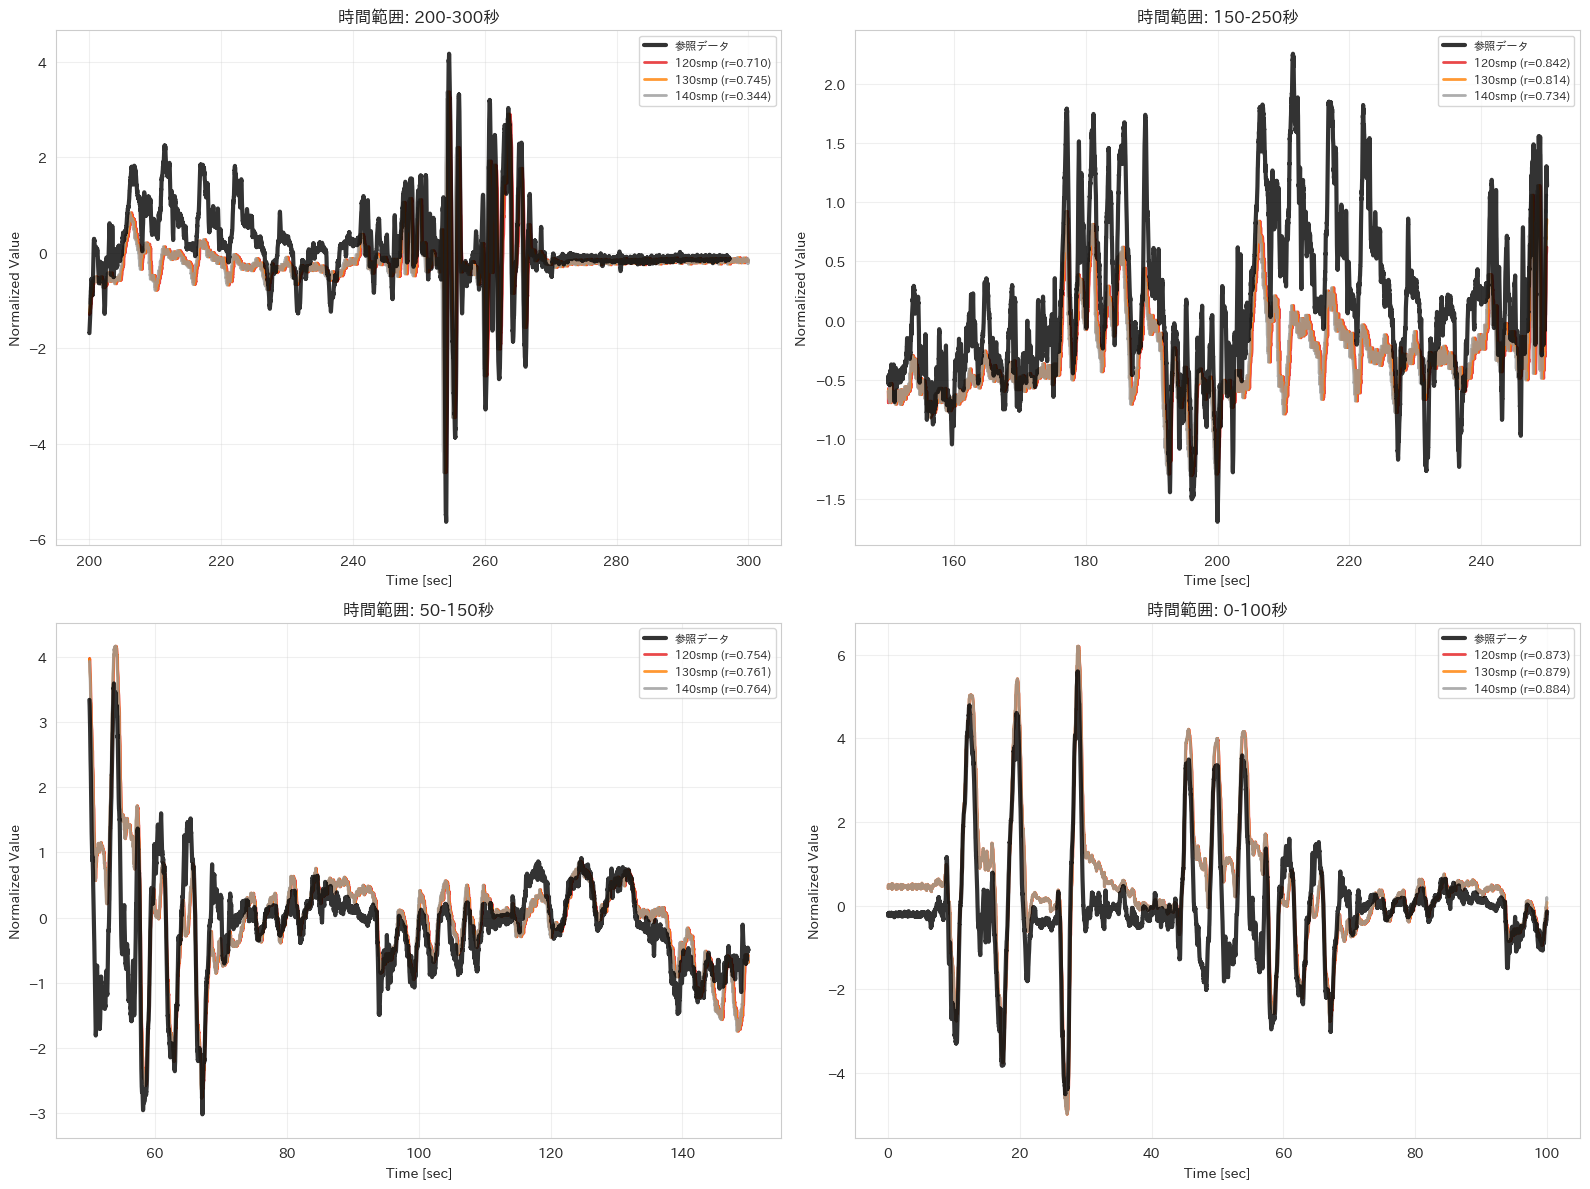


=== 指定ドリフト量の全体相関 ===
ドリフト 120 サンプル: 全体相関 = 0.7789
ドリフト 130 サンプル: 全体相関 = 0.7887
ドリフト 140 サンプル: 全体相関 = 0.7208


In [7]:
def compare_detailed_samples(df_ref, df_target, specific_drifts, 
                           col_ref='COP_X', col_target='圧力中心列_2',
                           focus_range=(200, 300)):
    """
    特定のドリフト量を詳細に比較（複数区間で表示）
    """
    
    # --- 前処理 ---
    ref_data = df_ref[col_ref]
    ref_norm = (ref_data - ref_data.mean()) / ref_data.std()
    
    target_data = df_target[col_target]
    target_norm = (target_data - target_data.mean()) / target_data.std()
    
    dt_mean = df_target['time'].diff().mean()
    t_start = df_target['time'].min()
    t_end_orig = df_target['time'].max()
    duration = t_end_orig - t_start
    
    # --- 複数サブプロットで表示 ---
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    # カラーマップ
    colors = plt.cm.Set1(np.linspace(0, 1, len(specific_drifts)))
    
    # 各注目区間をプロット
    focus_ranges = [
        (200, 300),  # 後半部分
        (150, 250),  # 中間部分
        (50, 150),   # 前半部分
        (0, 100)     # 最初の部分
    ]
    
    for ax_idx, (start_time, end_time) in enumerate(focus_ranges):
        if ax_idx >= len(axes):
            break
            
        ax = axes[ax_idx]
        
        # 参照データ
        mask_ref = (df_ref['time'] >= start_time) & (df_ref['time'] <= end_time)
        ax.plot(df_ref['time'][mask_ref], ref_norm[mask_ref], 
                color='black', linewidth=3, alpha=0.8, 
                label='参照データ', zorder=10)
        
        # 各ドリフト量
        for i, drift_samples in enumerate(specific_drifts):
            total_lag_time = drift_samples * dt_mean
            scale_factor = duration / (duration + total_lag_time)
            new_time = t_start + (df_target['time'] - t_start) * scale_factor
            
            # 相関係数計算（この区間のみ）
            mask_target = (new_time >= start_time) & (new_time <= end_time)
            if np.sum(mask_target) > 5:
                # この区間内での相関を計算
                time_in_range = new_time[mask_target]
                values_in_range = target_norm[mask_target]
                
                # 参照データと同じ時間点に補間
                from scipy import interpolate
                f_interp = interpolate.interp1d(time_in_range, values_in_range, 
                                              bounds_error=False, fill_value='extrapolate')
                target_aligned = f_interp(df_ref['time'][mask_ref])
                
                # 相関計算
                valid_mask = ~np.isnan(target_aligned)
                if np.sum(valid_mask) > 5:
                    correlation = np.corrcoef(ref_norm[mask_ref][valid_mask], 
                                            target_aligned[valid_mask])[0,1]
                else:
                    correlation = 0
            else:
                correlation = 0
            
            # プロット
            ax.plot(new_time[mask_target], target_norm[mask_target],
                   color=colors[i], linewidth=2, alpha=0.8,
                   label=f'{drift_samples}smp (r={correlation:.3f})')
        
        ax.set_title(f'時間範囲: {start_time}-{end_time}秒')
        ax.set_xlabel('Time [sec]')
        ax.set_ylabel('Normalized Value')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # 各ドリフト量の全体相関も表示
    print("\n=== 指定ドリフト量の全体相関 ===")
    for drift_samples in specific_drifts:
        total_lag_time = drift_samples * dt_mean
        scale_factor = duration / (duration + total_lag_time)
        new_time = t_start + (df_target['time'] - t_start) * scale_factor
        
        # 補間
        from scipy import interpolate
        f_interp = interpolate.interp1d(new_time, target_norm, 
                                      bounds_error=False, fill_value='extrapolate')
        target_aligned = f_interp(df_ref['time'])
        
        # 全体相関
        valid_mask = ~np.isnan(target_aligned)
        if np.sum(valid_mask) > 10:
            overall_correlation = np.corrcoef(ref_norm[valid_mask], target_aligned[valid_mask])[0,1]
            print(f"ドリフト {drift_samples:3d} サンプル: 全体相関 = {overall_correlation:.4f}")

# 特定のドリフト量を詳細比較
compare_detailed_samples(
    df_mock_tmp, 
    df_seat, 
    specific_drifts=[120, 130, 140],  # 比較したい特定の値
    col_ref='COP_X', 
    col_target='圧力中心列_2'
)

補正情報:
  - ズレサンプル数: 126
  - ズレ時間換算  : 3.0002 sec
  - 適用スケール  : 0.99049845


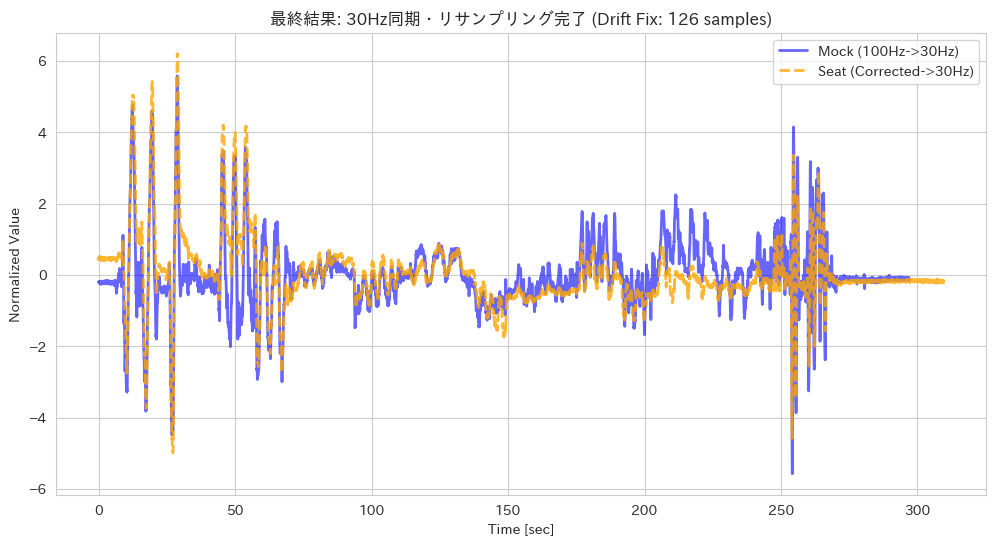

--- df_mock_30hz ---
       time     COP_X     COP_Y     steer       trg     pedal
0  0.000000  0.011814 -0.021516 -0.565450  5.055610  0.375131
1  0.033333  0.011866 -0.022303 -0.563513  5.055717  0.375783
2  0.066667  0.011679 -0.021782 -0.564624  5.055546  0.376217
3  0.100000  0.011824 -0.022071 -0.567672  0.000025  0.375131
4  0.133333  0.011552 -0.021779 -0.568205  0.000017  0.375131

--- df_seat_30hz ---
       time  平均圧力_1  最低圧力_1   ピーク圧力_1  接触域 (cm²)_1  選択領域(cm²)_1     接触 %_1  \
0  0.000000    0.32    0.13  1.320000  1051.610000      2580.65  40.750000   
1  0.033333    0.32    0.13  1.321956  1053.540855      2580.65  40.827712   
2  0.066667    0.32    0.13  1.326788  1051.610000      2580.65  40.750000   
3  0.100000    0.32    0.13  1.345034  1060.487982      2580.65  41.097721   
4  0.133333    0.32    0.13  1.323495  1062.262327      2580.65  41.162629   

      荷重(N)_1  標準偏差_1  平均_1  ...  最低圧力_2   ピーク圧力_2  接触域 (cm²)_2  選択領域(cm²)_2  \
0  337.820000    0.21   0.3  ...    

In [8]:


# =========================================================
# 1. パラメータ設定
# =========================================================
BEST_DRIFT_SAMPLES = 126  # 見つけたベストな値
TARGET_FS = 30.0           # 目標サンプリング周波数 (Hz)

# =========================================================
# 2. df_seat の時間軸を補正（永続化）
# =========================================================
def apply_drift_correction(df, drift_samples):
    """
    見つけたドリフト量(samples)に基づいて時間軸を実際に書き換える
    """
    df_fixed = df.copy()
    
    # 統計量の計算
    dt_mean = df_fixed['time'].diff().mean()
    t_start = df_fixed['time'].min()
    t_end   = df_fixed['time'].max()
    duration = t_end - t_start
    
    # ズレ時間の計算 (35サンプル * 1サンプルの時間)
    total_lag_time = drift_samples * dt_mean
    
    # 伸縮率 (Scale Factor) の計算
    # visualize関数と同じ計算式を使用
    scale_factor = duration / (duration + total_lag_time)
    
    print(f"補正情報:")
    print(f"  - ズレサンプル数: {drift_samples}")
    print(f"  - ズレ時間換算  : {total_lag_time:.4f} sec")
    print(f"  - 適用スケール  : {scale_factor:.8f}")
    
    # 時間軸の更新
    df_fixed['time'] = t_start + (df_fixed['time'] - t_start) * scale_factor
    
    return df_fixed

# df_seat の時間を修正
df_seat_fixed = apply_drift_correction(df_seat, BEST_DRIFT_SAMPLES)


# =========================================================
# 3. 共通の30Hzへのリサンプリング
# =========================================================
def resample_to_target_hz(df, time_col, data_cols, target_fs):
    """
    指定されたDataFrameをtarget_fs(Hz)にリサンプリングする関数
    """
    # 元データ
    t_src = df[time_col].values
    # 時間軸の開始と終了（データの範囲内）
    t_min, t_max = t_src.min(), t_src.max()
    
    # 新しい時間軸 (startからendまで 1/fs 刻み)
    new_time = np.arange(t_min, t_max, 1.0 / target_fs)
    
    # 結果格納用DataFrame
    df_resampled = pd.DataFrame({time_col: new_time})
    
    # 指定されたデータ列を補間
    for col in data_cols:
        # 線形補間 (linear) または 3次スプライン (cubic)
        f = interpolate.interp1d(t_src, df[col].values, kind='linear', fill_value="extrapolate")
        df_resampled[col] = f(new_time)
        
    return df_resampled

# --- リサンプリング実行 ---

mock_cols = ['COP_X', 'COP_Y', 'steer', 'trg', 'pedal']
seat_cols = ['平均圧力_1', '最低圧力_1',
       'ピーク圧力_1', '接触域 (cm²)_1', '選択領域(cm²)_1', '接触 %_1', '荷重(N)_1', '標準偏差_1',
       '平均_1', '圧力中心行_1', '圧力中心列_1', '平均圧力_2', '最低圧力_2', 'ピーク圧力_2',
       '接触域 (cm²)_2', '選択領域(cm²)_2', '接触 %_2', '荷重(N)_2', '標準偏差_2', '平均_2',
       '圧力中心行_2', '圧力中心列_2']

# df_mock_tmp (元100Hz) -> 30Hz
df_mock_30hz = resample_to_target_hz(
    df_mock_tmp, 
    time_col='time', 
    data_cols=mock_cols, # 必要な列を指定
    target_fs=TARGET_FS
)

# df_seat_fixed (補正済み40Hz) -> 30Hz
df_seat_30hz = resample_to_target_hz(
    df_seat_fixed, 
    time_col='time', 
    data_cols=seat_cols, # 必要な列を指定
    target_fs=TARGET_FS
)


# =========================================================
# 4. 結果の確認（結合・プロット）
# =========================================================

# 時間軸を完全に合わせるため、共通の時間範囲でデータを結合（Merge）しても良いですが、
# ここではプロットで確認します。

# 正規化関数（比較用）
def z_score(series):
    return (series - series.mean()) / series.std()

plt.figure(figsize=(12, 6))

# 青: df_mock (30Hz)
plt.plot(df_mock_30hz['time'], z_score(df_mock_30hz['COP_X']), 
         label='Mock (100Hz->30Hz)', color='blue', alpha=0.6, linewidth=2)

# オレンジ: df_seat (補正済み->30Hz)
plt.plot(df_seat_30hz['time'], z_score(df_seat_30hz['圧力中心列_2']), 
         label='Seat (Corrected->30Hz)', color='orange', alpha=0.8, linestyle='--', linewidth=2)

plt.title(f"最終結果: 30Hz同期・リサンプリング完了 (Drift Fix: {BEST_DRIFT_SAMPLES} samples)")
plt.xlabel("Time [sec]")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)

# ズレやすい後半を拡大
t_end = df_mock_30hz['time'].max()
# plt.xlim(t_end - 10, t_end) 

plt.show()

# データフレームの中身確認
print("--- df_mock_30hz ---")
print(df_mock_30hz.head())
print("\n--- df_seat_30hz ---")
print(df_seat_30hz.head())

In [9]:
df_all = pd.merge(df_mock_30hz, df_seat_30hz, on='time', how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)') 

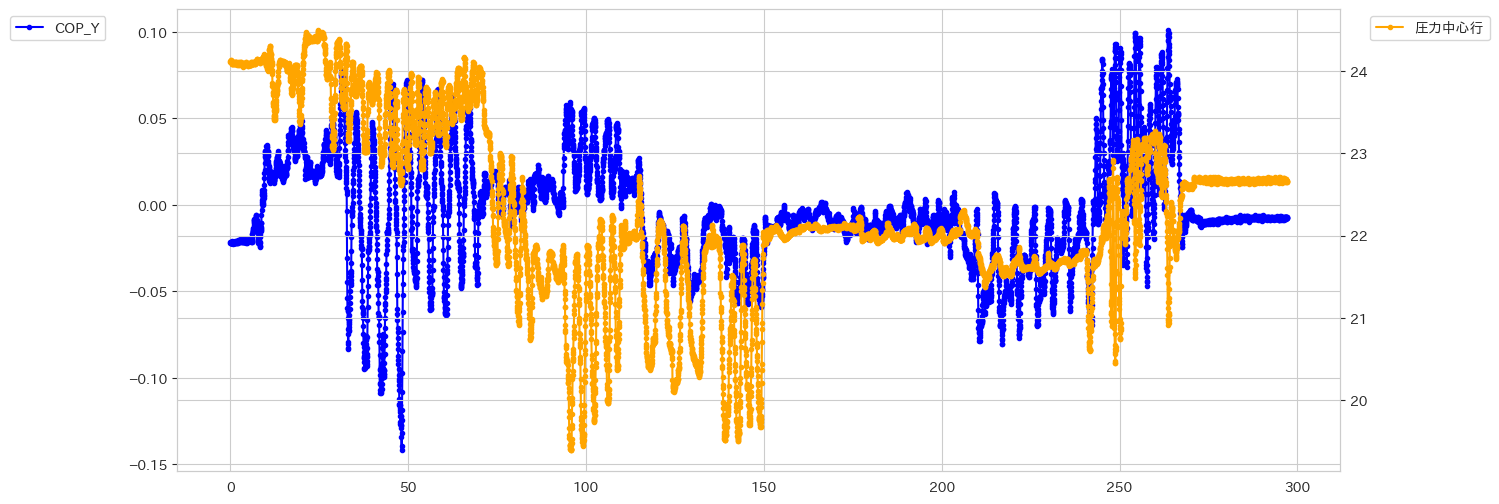

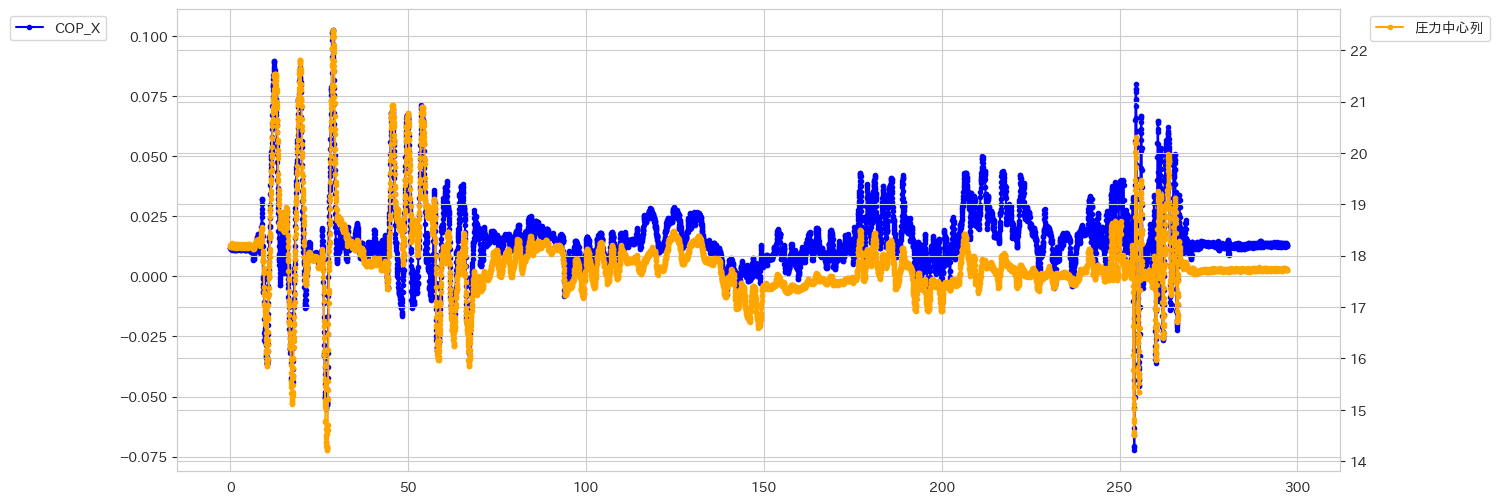

In [10]:

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1, 1, 1)
ax2 = ax1.twinx() 
ax1.plot(df_all.time,df_all['COP_Y'],'.-',color='blue',label='COP_Y')
ax2.plot(df_all['time'],df_all['圧力中心行_2'],'.-',color='orange',label='圧力中心行') 
ax1.legend(bbox_to_anchor=(-0.15, 1.0), loc='upper left')
ax2.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
plt.show()

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1, 1, 1)
ax2 = ax1.twinx() 
ax1.plot(df_all["time"],df_all['COP_X'],'.-',color='blue',label='COP_X')
ax2.plot(df_all['time'],df_all['圧力中心列_2'],'.-',color='orange',label='圧力中心列') # Y
ax1.legend(bbox_to_anchor=(-0.15, 1.0), loc='upper left')
ax2.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
plt.show()

In [11]:

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score


# 1. データ準備
features = [ 
    'ピーク圧力_1', '接触域 (cm²)_1', '選択領域(cm²)_1', '接触 %_1', '荷重(N)_1', '圧力中心行_1', '圧力中心列_1', 
    '平均圧力_2', 'ピーク圧力_2', '接触域 (cm²)_2', '選択領域(cm²)_2', '接触 %_2', '荷重(N)_2', 
    '圧力中心行_2', '圧力中心列_2','pedal','steer'
]
targets = ['COP_X', 'COP_Y']

# --- ここが修正ポイント: NaNを含む行を削除する ---
# Xとyを結合して、どちらかにNaNがあればその行ごと捨てる
temp_df = df_all[features + targets].dropna()

# 削除後のデータサイズ確認
print(f"元のデータ数: {len(df_all)}")
print(f"NaN除去後のデータ数: {len(temp_df)}")
print(f"削除された行数: {len(df_all) - len(temp_df)}")

if len(temp_df) == 0:
    raise ValueError("すべてがNaNとして削除されました。データの読み込みを確認してください。")

X = temp_df[features]
y = temp_df[targets]

元のデータ数: 8914
NaN除去後のデータ数: 8914
削除された行数: 0


=== 多重共線性（相関 > 0.80）が疑われる特徴量ペア ===
接触 %_1           <->  接触域 (cm²)_1       相関 = 1.000
荷重(N)_1          <->  接触域 (cm²)_1       相関 = 0.943
荷重(N)_1          <->  接触 %_1            相関 = 0.943
圧力中心行_1          <->  接触域 (cm²)_1       相関 = 0.905
圧力中心行_1          <->  接触 %_1            相関 = 0.905
圧力中心行_1          <->  荷重(N)_1           相関 = 0.831
接触 %_2           <->  接触域 (cm²)_2       相関 = 1.000


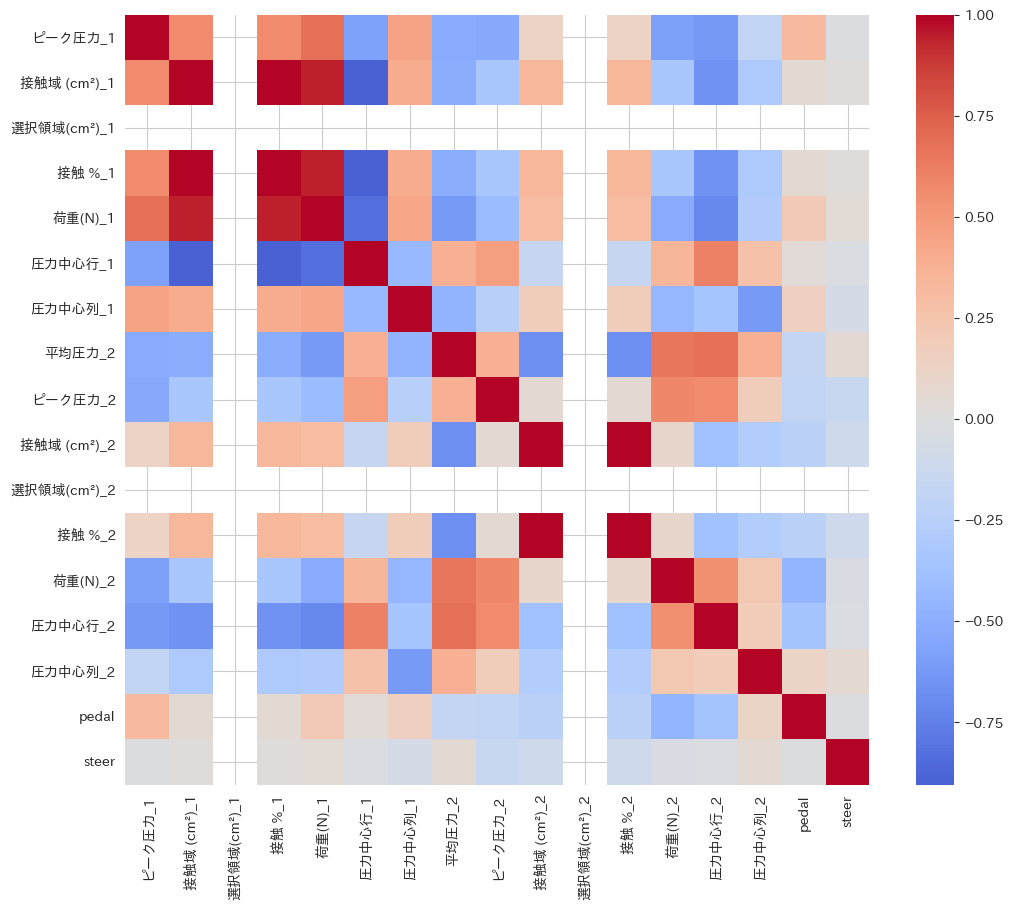

In [12]:

# 相関行列を計算
corr_matrix = temp_df[features].corr().abs()

plt.figure(figsize=(12,10))
sns.heatmap(temp_df[features].corr(), cmap='coolwarm', center=0)

# 上三角行列を抽出（重複と自己相関を除外）
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 閾値（マルチコ検出基準）
threshold = 0.8  # 必要なら 0.9 に変更もOK

# マルチコしてそうなペアを抽出
multicol_pairs = [
    (col, row, upper_triangle.loc[row, col])
    for col in upper_triangle.columns
    for row in upper_triangle.index
    if upper_triangle.loc[row, col] > threshold
]

# 結果表示
print("=== 多重共線性（相関 > {:.2f}）が疑われる特徴量ペア ===".format(threshold))
for f1, f2, corr_value in multicol_pairs:
    print(f"{f1:15s}  <->  {f2:15s}   相関 = {corr_value:.3f}")


学習データ数: 6814
テストデータ数: 2100
----------------------------------------
Test Ranges: [(400, 500), (700, 800), (1100, 1200), (1400, 1500), (1800, 1900), (2500, 2700), (3400, 3600), (4400, 4500), (5400, 5600), (6400, 6700), (7400, 8000)]
Total R2 Score: 0.8302
COP_X (左右) -> R2: 0.7344, RMSE: 0.009
COP_Y (前後) -> R2: 0.9261, RMSE: 0.012
----------------------------------------


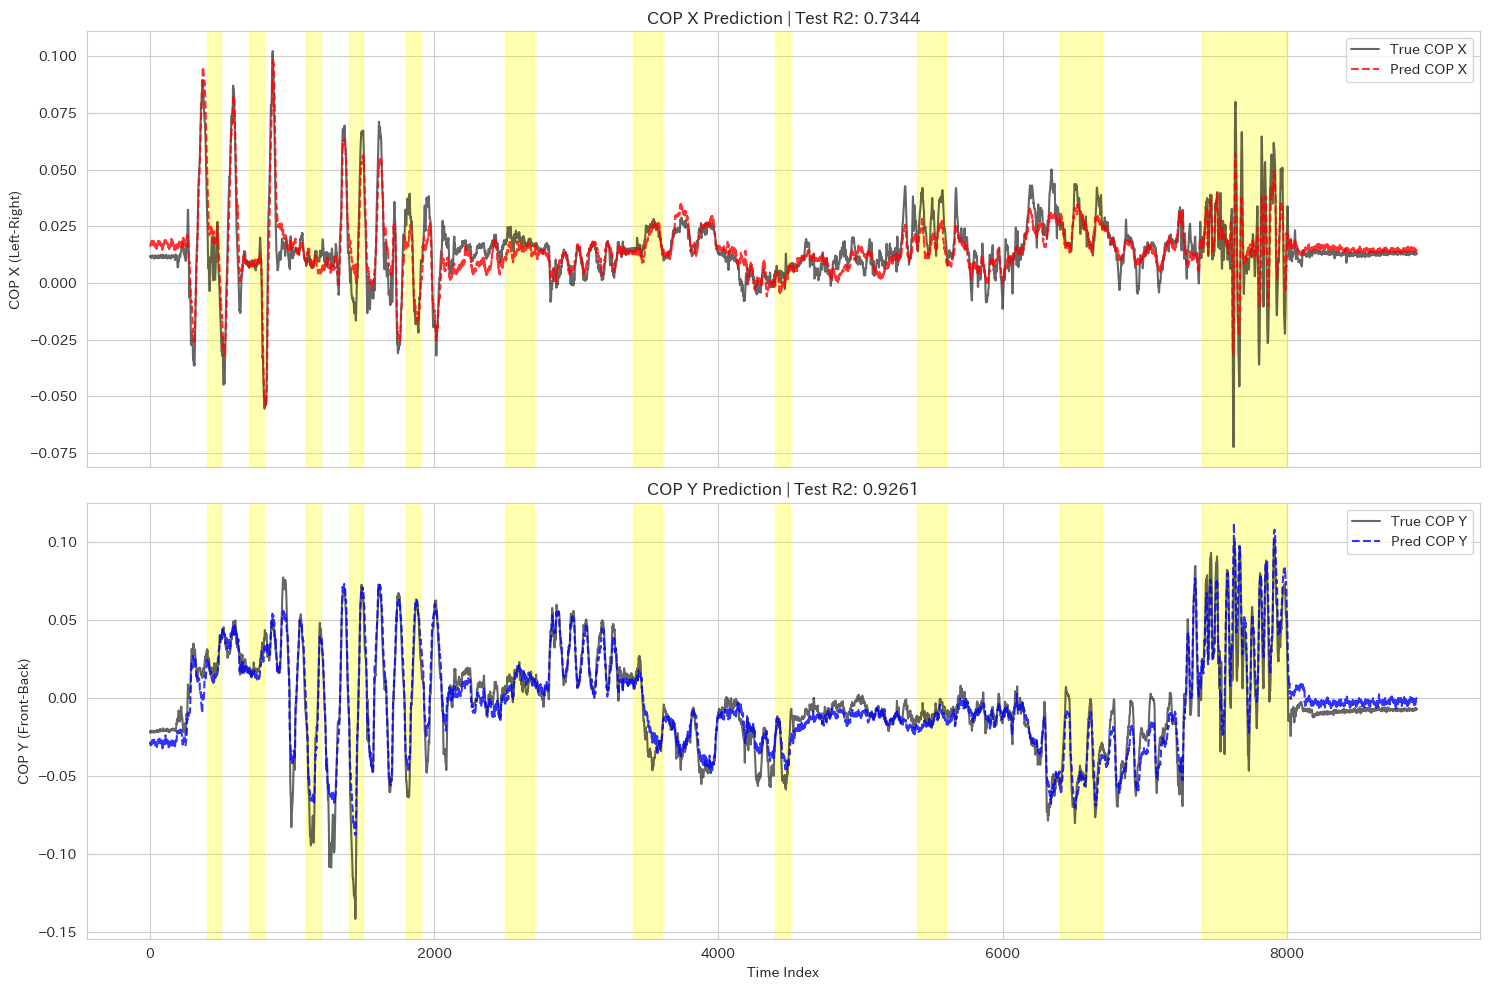

Train R2 COP_X: 0.8378624310205355
Train R2 COP_Y: 0.9086855318414493


In [13]:

# --- Cell 6 (改良版): Custom Split Evaluation (COP X & Y 両方を表示) ---
import matplotlib.patches as patches
from sklearn.metrics import mean_squared_error, r2_score

# 1. テストデータの区間定義 (start, end)
test_ranges = [
    (400, 500),
    (700, 800),
    (1100, 1200),
    (1400, 1500),
    (1800, 1900),
    (2500, 2700),
    (3400, 3600),
    (4400, 4500),
    (5400, 5600),
    (6400, 6700),
    (7400, 8000)
]
# test_ranges = [
#     (1200, 1500)
# ]

# 2. マスク（フィルタ）の作成
n_samples = len(X)
is_test_mask = np.zeros(n_samples, dtype=bool)

for start, end in test_ranges:
    s = max(0, start)
    e = min(n_samples, end)
    is_test_mask[s:e] = True

# 3. データの分割
X_train = X[~is_test_mask]
y_train = y[~is_test_mask]

X_test = X[is_test_mask]
y_test = y[is_test_mask]

print(f"学習データ数: {len(X_train)}")
print(f"テストデータ数: {len(X_test)}")

# 4. モデル構築と学習
custom_model = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge(alpha=1.0))
])

custom_model.fit(X_train, y_train)

# 5. テストデータに対する評価 (個別スコア計算)
y_pred_test = custom_model.predict(X_test)

# 全体のスコア
r2_total = r2_score(y_test, y_pred_test)

# X軸 (左右) と Y軸 (前後) 個別のスコア
r2_x = r2_score(y_test.iloc[:, 0], y_pred_test[:, 0])
r2_y = r2_score(y_test.iloc[:, 1], y_pred_test[:, 1])
rmse_x = np.sqrt(mean_squared_error(y_test.iloc[:, 0], y_pred_test[:, 0]))
rmse_y = np.sqrt(mean_squared_error(y_test.iloc[:, 1], y_pred_test[:, 1]))

print("-" * 40)
print(f"Test Ranges: {test_ranges}")
print(f"Total R2 Score: {r2_total:.4f}")
print(f"COP_X (左右) -> R2: {r2_x:.4f}, RMSE: {rmse_x:.3f}")
print(f"COP_Y (前後) -> R2: {r2_y:.4f}, RMSE: {rmse_y:.3f}")
print("-" * 40)

# 6. 可視化（XとYを上下に並べて表示）
y_pred_all = custom_model.predict(X)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# --- 上段: COP X ---
ax1.plot(y.values[:, 0], label='True COP X', color='black', alpha=0.6)
ax1.plot(y_pred_all[:, 0], label='Pred COP X', color='red', linestyle='--', alpha=0.8)
ax1.set_ylabel("COP X (Left-Right)")
ax1.set_title(f"COP X Prediction | Test R2: {r2_x:.4f}")
ax1.legend(loc='upper right')
ax1.grid(True)

# --- 下段: COP Y ---
ax2.plot(y.values[:, 1], label='True COP Y', color='black', alpha=0.6)
ax2.plot(y_pred_all[:, 1], label='Pred COP Y', color='blue', linestyle='--', alpha=0.8)
ax2.set_ylabel("COP Y (Front-Back)")
ax2.set_title(f"COP Y Prediction | Test R2: {r2_y:.4f}")
ax2.set_xlabel("Time Index")
ax2.legend(loc='upper right')
ax2.grid(True)

# --- テスト区間のハイライト (両方のグラフに適用) ---
for ax in [ax1, ax2]:
    for start, end in test_ranges:
        if end > len(y): break
        # 凡例に一度だけ表示させるための工夫
        label_name = 'Test Range' if (ax == ax1 and start == test_ranges[0][0]) else ""
        ax.axvspan(start, end, color='yellow', alpha=0.3, label=label_name)

plt.tight_layout()
plt.show()


y_pred_train = custom_model.predict(X_train)

print("Train R2 COP_X:", r2_score(y_train.iloc[:,0], y_pred_train[:,0]))
print("Train R2 COP_Y:", r2_score(y_train.iloc[:,1], y_pred_train[:,1]))

<Figure size 1200x1000 with 0 Axes>

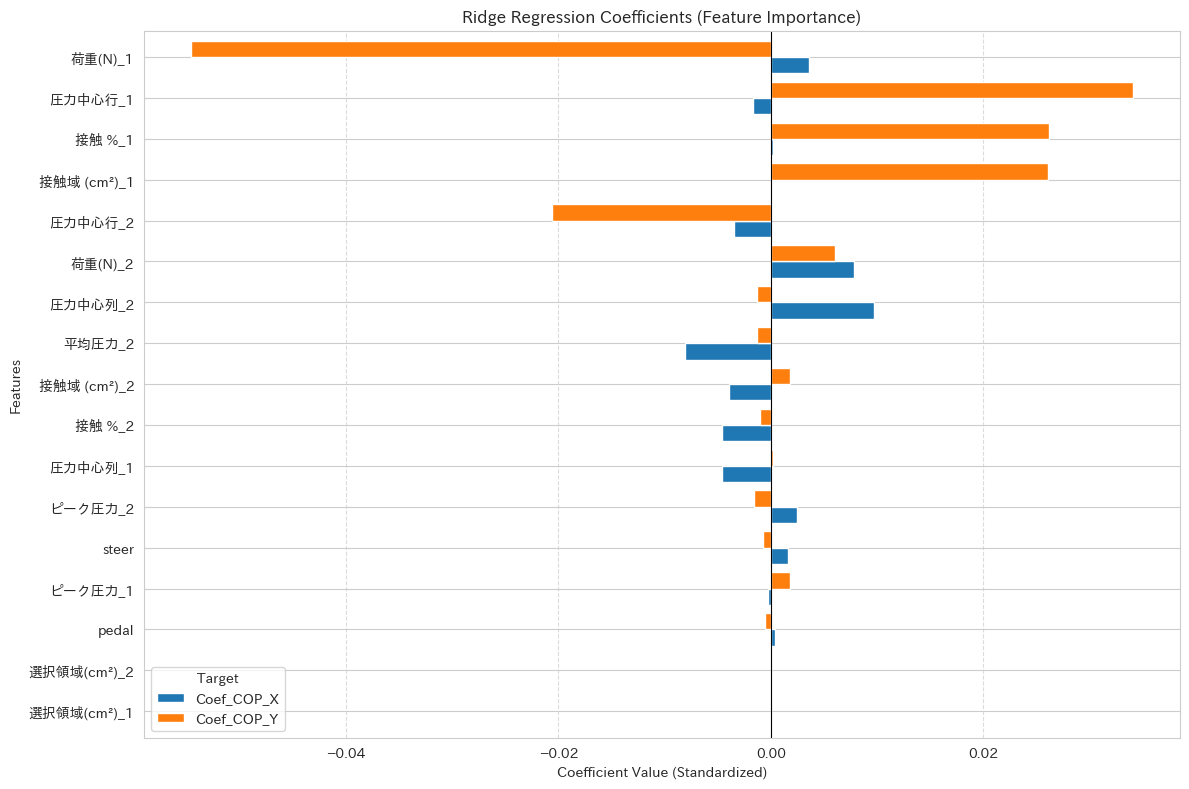

--- Top 5 Important Features for COP X (Left-Right) ---
圧力中心列_2    0.009699
平均圧力_2    -0.008083
荷重(N)_2    0.007840
圧力中心列_1   -0.004590
接触 %_2    -0.004590
Name: Coef_COP_X, dtype: float64

--- Top 5 Important Features for COP Y (Front-Back) ---
荷重(N)_1       -0.054599
圧力中心行_1        0.034107
接触 %_1         0.026170
接触域 (cm²)_1    0.026093
圧力中心行_2       -0.020574
Name: Coef_COP_Y, dtype: float64


In [14]:

# --- Cell 7: Feature Importance Visualization ---
import seaborn as sns

# 1. パイプラインからRidgeモデルと係数を取得
# custom_model.named_steps['regressor'] でRidgeオブジェクトにアクセス
ridge_model = custom_model.named_steps['regressor']
coefs = ridge_model.coef_  # Shape: (2, n_features) -> (COP_X, COP_Y)

# 特徴量名
feature_names = features

# 2. データフレームにまとめる
df_coef = pd.DataFrame(
    coefs.T, 
    columns=['Coef_COP_X', 'Coef_COP_Y'], 
    index=feature_names
)

# 3. 重要度（絶対値の合計）でソート
df_coef['Abs_Importance'] = df_coef.abs().sum(axis=1)
df_coef_sorted = df_coef.sort_values(by='Abs_Importance', ascending=True) # グラフ用に昇順

# 不要な列（ソート用）を削除して、プロット用データ作成
plot_data = df_coef_sorted[['Coef_COP_X', 'Coef_COP_Y']]

# 4. 可視化 (水平棒グラフ)
plt.figure(figsize=(12, 10))

# pandasのplot機能を使用
plot_data.plot(kind='barh', figsize=(12, 8), width=0.8)

plt.title("Ridge Regression Coefficients (Feature Importance)")
plt.xlabel("Coefficient Value (Standardized)")
plt.ylabel("Features")
plt.axvline(x=0, color='black', linewidth=0.8) # ゼロライン
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend(title="Target")

plt.tight_layout()
plt.show()

# 5. 上位5つの重要な特徴量を表示
print("--- Top 5 Important Features for COP X (Left-Right) ---")
top_x = df_coef['Coef_COP_X'].abs().sort_values(ascending=False).head(5)
print(df_coef.loc[top_x.index, 'Coef_COP_X'])

print("\n--- Top 5 Important Features for COP Y (Front-Back) ---")
top_y = df_coef['Coef_COP_Y'].abs().sort_values(ascending=False).head(5)
print(df_coef.loc[top_y.index, 'Coef_COP_Y'])

最適なalphaを探索中...
★ 最適な alpha: 0.1
----------------------------------------
Train R2 Score: 0.8733
Test  R2 Score: 0.8302
Gap (Train - Test): 0.0431
判定: ✅ 良好な汎化性能 (Gapが小さい)
----------------------------------------


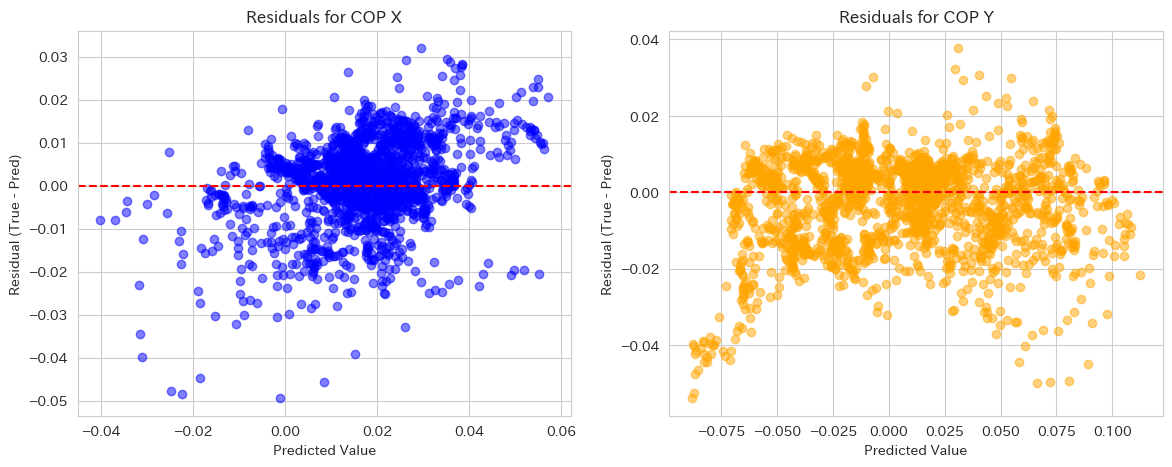

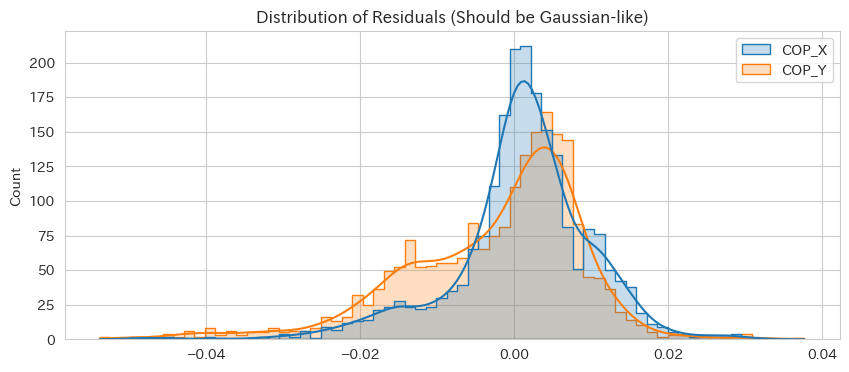

In [15]:

# --- Cell 8: Robustness Check (過学習確認 & パラメータ探索) ---
from sklearn.linear_model import RidgeCV

# 1. ハイパーパラメータ探索 (RidgeCV)
# alpha（正則化の強さ）を 0.1 ~ 1000 の範囲で自動で試してベストを探す
alphas = [0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0]

# Cross-Validation付きのRidge
ridge_cv = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RidgeCV(alphas=alphas, scoring='r2'))
])

print("最適なalphaを探索中...")
ridge_cv.fit(X_train, y_train)

# ベストなalphaを表示
best_alpha = ridge_cv.named_steps['regressor'].alpha_
print(f"★ 最適な alpha: {best_alpha}")
if best_alpha == max(alphas):
    print("警告: alphaが探索範囲の上限です。もっと大きな値を試すべきかもしれません。")

# 2. 過学習の確認 (Train vs Test Score)
y_pred_train = ridge_cv.predict(X_train)
y_pred_test = ridge_cv.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print("-" * 40)
print(f"Train R2 Score: {r2_train:.4f}")
print(f"Test  R2 Score: {r2_test:.4f}")
print(f"Gap (Train - Test): {r2_train - r2_test:.4f}")

if r2_train - r2_test > 0.15:
    print("判定: ⚠️ 過学習の疑いあり (学習データに適合しすぎています)")
elif r2_test > r2_train:
    print("判定: ❓ テストデータの方がスコアが良い (データ分布の偏りの可能性)")
else:
    print("判定: ✅ 良好な汎化性能 (Gapが小さい)")
print("-" * 40)

# 3. 残差プロット (Residual Plot)
# 予測値と、実際の値とのズレ（残差）をプロットします
residuals = y_test - y_pred_test

plt.figure(figsize=(14, 5))

# X軸方向の残差
plt.subplot(1, 2, 1)
plt.scatter(y_pred_test[:, 0], residuals.iloc[:, 0], alpha=0.5, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals for COP X")
plt.xlabel("Predicted Value")
plt.ylabel("Residual (True - Pred)")
plt.grid(True)

# Y軸方向の残差
plt.subplot(1, 2, 2)
plt.scatter(y_pred_test[:, 1], residuals.iloc[:, 1], alpha=0.5, color='orange')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals for COP Y")
plt.xlabel("Predicted Value")
plt.ylabel("Residual (True - Pred)")
plt.grid(True)

plt.show()

# 残差のヒストグラム（正規分布に近いか？）
plt.figure(figsize=(10, 4))
sns.histplot(residuals, kde=True, element="step")
plt.title("Distribution of Residuals (Should be Gaussian-like)")
plt.show()